In [780]:
import torch
from torch import nn,optim
import torch.nn.functional
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os as os
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,multilabel_confusion_matrix
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from scipy.stats import kurtosis,skew
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import f_classif
import scipy.stats
from sklearn.preprocessing import MinMaxScaler,StandardScaler


from sklearn.model_selection import cross_val_score

#import warnings

#warnings.simplefilter(action='ignore', category=FutureWarning)



<h1>Train data prep</h1>

una osservazione ogni secondo <br>
1200 osservazioni per dataframe<br>
Le colonne P1-P7 sono pressioni nei punti di misurazione<br>

In [781]:
path_train = '/Users/alexdediu/git-projects/Data-Challenge-PHM-Asia-Pacific-2023/dataset/train'
path_data = "/data"
path_labels = "/labels.xlsx"


dfs_data = []

for filename in os.listdir(path_train+path_data):
    if filename.endswith('.csv'):
       
        percorso_file = os.path.join(path_train+path_data, filename)
        df = pd.read_csv(percorso_file)
        dfs_data.append(df)

df_data = pd.concat(dfs_data, ignore_index=True)

df_data



,TIME,P1,P2,P3,P4,P5,P6,P7
0,0.000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
1,0.001,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
2,0.002,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
3,0.003,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
4,0.004,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
...,...,...,...,...,...,...,...,...
212572,1.196,1.952063,1.908461,1.934484,1.837319,1.921240,1.912475,1.919641
212573,1.197,1.949134,1.915494,1.885116,1.827055,1.916485,1.907144,1.881396
212574,1.198,1.956077,1.922930,1.902461,1.887422,1.925576,1.916930,1.927116
212575,1.199,1.968020,1.958794,1.962051,1.912295,1.942300,1.941114,1.904265


In [782]:
traces = []
for column in df.columns:
    if column != 'TIME':  
        trace = go.Scatter(x=df['TIME'], y=df[column], mode='lines', name=column)
        traces.append(trace)


layout = go.Layout(title='Line Plot per le colonne del DataFrame',
                   xaxis=dict(title='TIME'),
                   yaxis=dict(title='Valore'))


fig = go.Figure(data=traces, layout=layout)


fig.show()

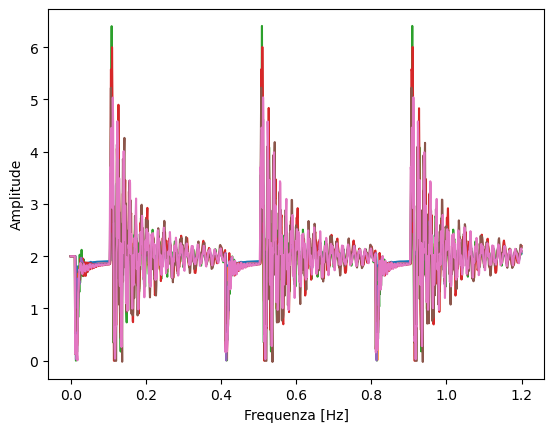

In [783]:
temp = dfs_data[0].copy()
temp = temp.drop(columns=["TIME"])
plt.plot(dfs_data[0]["TIME"],temp)
plt.xlabel('Frequenza [Hz]')
plt.ylabel('Amplitude')
plt.show()


Creazione dei df per FFT.

eliminazione della frequenza 0 (componente DC).

fftfreq calcola le frequenze associate ai coefficienti ottenuti dalla fft.

il plot seguente ha sull'asse x le frequenze e sull'asse y la fft.

per la ftt basta la parte reale o bisogna mantenere anche la fase (parte immaginaria)?


In [784]:
# import pandas as pd
# import numpy as np
# import scipy.stats

# dfs_freq = []
# dfs_fft = []
# freq_dom = []

# for df in dfs_data:
#     fft_df = pd.DataFrame()
#     fft_freq = pd.DataFrame()
#     freq_dom_col = pd.DataFrame()

#     for col in df.columns:
#         if col != "TIME":
#             fft_result = np.fft.fft(df[col]).real
#             freq = np.fft.fftfreq(len(df[col]))

#             # Eliminazione della frequenza 0 (media della serie temporale originale)
#             fft_result = fft_result[1:]
#             freq = freq[1:]

#             # Individuazione della frequenza dominante
#             index_dominant_peak = np.argmax(np.abs(fft_result))
#             dominant_freq = freq[index_dominant_peak]
#             spettro_potenza = np.abs(fft_result) ** 2
#             mean_power_spectrum = np.mean(spettro_potenza)
#             print(spettro_potenza)
#             # Calcolo dell'energia
#             energia = np.sum(spettro_potenza)
#             # Calcola la distribuzione di probabilità dei valori nel segnale
#             prob_dist = np.abs(np.fft.fft(df[col]).real) ** 2 / np.sum(np.abs(np.fft.fft(df[col]).real) ** 2)

#             # Calcola l'entropia utilizzando la distribuzione di probabilità
#             entropia = scipy.stats.entropy(prob_dist)
#             max_val = np.max(np.abs(fft_result[1:]))

#             # Calcola il valore impulsivo
#             impulse_factor = max_val / np.mean(np.abs(df[col]))

#             # Calcola il valore di picco
#             crest_factor = max_val / np.sqrt(np.mean(np.square(df[col])))

#             # Aggiungi crest factor e impulse factor al DataFrame
#             freq_dom_col[col + "_crest_factor"] = [crest_factor]
#             freq_dom_col[col + "_impulse_factor"] = [impulse_factor]

#             # Aggiungi l'entropia al DataFrame
#             # freq_dom_col[col + "_entropia"] = [entropia]

#             # Aggiungi la frequenza dominante al DataFrame
#             # freq_dom_col[col + "_freq_dom"] = [dominant_freq]
            
#             # Aggiungi l'energia al DataFrame
#             # freq_dom_col[col + "_energia"] = [energia]

#             # Calcola lo spettro di frequenza
#             freq_dom_col[col + "_spettro_potenza"] = [mean_power_spectrum]

#             fft_df[col + '_fft'] = fft_result
#             # fft_freq[col + '_freq'] = freq

#     dfs_freq.append(fft_freq)
#     dfs_fft.append(fft_df)
#     freq_dom.append(freq_dom_col)

# # Concatenazione dei DataFrame delle frequenze dominanti
# df_freq_dom = pd.concat(freq_dom, axis=0)

# # Visualizzazione del DataFrame delle frequenze dominanti
# print(df_freq_dom)


In [785]:
sampling_rate = 1000  # 1 kHz

signal_length_ms = 1200

In [786]:
import pandas as pd
import numpy as np
from scipy import signal
from scipy.stats import skew, kurtosis

def stats_spectrum( spectrum):
    mean_power_spectrum = np.mean(spectrum)

    sum_power_spectrum = np.sum(spectrum)

    std_power_spectrum = np.std(spectrum)

    skewness_power_spectrum = skew(spectrum)

    kurtosis_power_spectrum = kurtosis(spectrum)

    return mean_power_spectrum, sum_power_spectrum, std_power_spectrum, skewness_power_spectrum, kurtosis_power_spectrum



 



In [787]:

def calculate_spectral_features(time_series,freqs,spectrum):
   

    signal_power = np.sum(spectrum)
    noise_power = np.sum(spectrum[freqs > 0.5 * sampling_rate])
    distortion_power = signal_power - noise_power 

    epsilon = 1e-10
    snr = 10 * np.log10(signal_power / (noise_power + epsilon))

    sinad = 10 * np.log10(signal_power / (noise_power + distortion_power + epsilon))

    peak_amplitude = np.max(time_series)

    band_power = np.sum(spectrum[(freqs >= 1) & (freqs <= 50)])

    peak_value = np.max(spectrum)

    peak_freq = freqs[np.argmax(spectrum)]

    mean_power_spectrum = np.mean(spectrum)

    sum_power_spectrum = np.sum(spectrum)

    return sinad, snr, peak_amplitude, band_power, peak_value, peak_freq, mean_power_spectrum, sum_power_spectrum

def calculate_additional_spectral_features(freqs,spectrum):
    

    prominent_harmonic_freq = freqs[np.argmax(spectrum)]

    harmonic_amplitude_ratio = np.max(spectrum) / np.mean(spectrum)

    main_harmonic_bandwidth = freqs[np.argmax(spectrum)] - freqs[np.argmin(spectrum)]

    relative_peak_freq = freqs[np.argmax(spectrum)] / prominent_harmonic_freq

    harmonic_energy = np.sum(spectrum)

    return prominent_harmonic_freq, harmonic_amplitude_ratio, main_harmonic_bandwidth, relative_peak_freq, harmonic_energy


dfs_freq = []
dfs_fft = []
freq_dom = []

for df in dfs_data:
    fft_df = pd.DataFrame()
    fft_freq = pd.DataFrame()
    freq_dom_col = pd.DataFrame()

    for col in df.columns:
        if col != "TIME":
            fft_result = np.fft.fft(df[col]).real
            
            freq = np.fft.fftfreq(len(df[col]), d=1/sampling_rate)


            fft_result = fft_result[1:]
            freq = freq[1:]
            power_spectrum = np.abs(fft_result) ** 2
          
       
       
            sinad, snr, peak_amplitude, band_power, peak_value, peak_freq, mean_power_spectrum, sum_power_spectrum = calculate_spectral_features(df[col],freq,power_spectrum)
            max_val = np.max(np.abs(fft_result[1:]))
            impulse_factor = max_val / np.mean(np.abs(df[col]))
            crest_factor = max_val / np.sqrt(np.mean(np.square(df[col])))
            mean_power_spectrum, sum_power_spectrum, std_power_spectrum, skewness_power_spectrum, kurtosis_power_spectrum = stats_spectrum(power_spectrum)

            freq_dom_col[col + "_SINAD"] = [sinad]
            freq_dom_col[col + "_SNR"] = [snr]
            freq_dom_col[col + "_crest_factor"] = [crest_factor]
            freq_dom_col[col + "_impulse_factor"] = [impulse_factor]
            freq_dom_col[col + "_PeakAmp"] = [peak_amplitude]
            freq_dom_col[col + "_BandPower"] = [band_power]
            freq_dom_col[col + "_PeakValue"] = [peak_value]
            freq_dom_col[col + "_PeakFreq"] = [peak_freq]
            # freq_dom_col[col + "_MeanPowerSpectrum"] = [mean_power_spectrum]
            freq_dom_col[col + "_SumPowerSpectrum"] = [sum_power_spectrum]
            # freq_dom_col[col + "_StdPowerSpectrum"] = [std_power_spectrum]
            # freq_dom_col[col + "_SkewnessPowerSpectrum"] = [skewness_power_spectrum]
            # freq_dom_col[col + "_KurtosisPowerSpectrum"] = [kurtosis_power_spectrum]
            # freq_dom_col[col + "_MeanPowerSpectrum"] = [mean_power_spectrum]
            # freq_dom_col[col + "_SumPowerSpectrum"] = [sum_power_spectrum]
            prominent_harmonic_freq, harmonic_amplitude_ratio, main_harmonic_bandwidth, relative_peak_freq, harmonic_energy = calculate_additional_spectral_features(freq,power_spectrum)
            
           
            # freq_dom_col[col + "_ProminentHarmonicFreq"] = [prominent_harmonic_freq]
            freq_dom_col[col + "_HarmonicAmplitudeRatio"] = [harmonic_amplitude_ratio]
            freq_dom_col[col + "_MainHarmonicBandwidth"] = [main_harmonic_bandwidth]
            # freq_dom_col[col + "_RelativePeakFreq"] = [relative_peak_freq]
            freq_dom_col[col + "_HarmonicEnergy"] = [harmonic_energy]

            fft_df[col + '_fft'] = fft_result
            fft_freq[col + '_freq'] = freq

    dfs_freq.append(fft_freq)
    dfs_fft.append(fft_df)
    freq_dom.append(freq_dom_col)

df_freq_dom = pd.concat(freq_dom, axis=0)

print(df_freq_dom)


        P1_SINAD      P1_SNR  P1_crest_factor  P1_impulse_factor  P1_PeakAmp  \
0  -7.714620e-15  147.574849        34.090442          34.451723    4.120726   
0  -7.714620e-15  147.544156        34.139211          34.504545    4.115485   
0  -6.750292e-15  148.291890        38.724438          39.188867    4.254711   
0  -6.750292e-15  148.268975        38.540183          39.001657    4.265872   
0  -6.750292e-15  148.293363        38.630333          39.094140    4.311454   
..           ...         ...              ...                ...         ...   
0  -6.750292e-15  148.292158        38.652616          39.116372    4.295627   
0  -6.750292e-15  148.302811        38.780259          39.245833    4.256737   
0  -6.750292e-15  148.291876        38.740086          39.204628    4.232319   
0  -9.161111e-15  146.841672        23.287829          23.504838    4.103252   
0  -8.196783e-15  147.256567        40.481763          40.948162    4.233148   

    P1_BandPower  P1_PeakValue  P1_Peak

In [788]:
freq_dom[0]

,P1_SINAD,P1_SNR,P1_crest_factor,P1_impulse_factor,P1_PeakAmp,P1_BandPower,P1_PeakValue,P1_PeakFreq,P1_SumPowerSpectrum,P1_HarmonicAmplitudeRatio,...,P7_crest_factor,P7_impulse_factor,P7_PeakAmp,P7_BandPower,P7_PeakValue,P7_PeakFreq,P7_SumPowerSpectrum,P7_HarmonicAmplitudeRatio,P7_MainHarmonicBandwidth,P7_HarmonicEnergy
0,-7.714620e-15,147.574849,34.090442,34.451723,4.120726,6912.261447,4673.230869,-59.950042,57211.704981,98.01975,...,63.394395,66.25336,5.040325,36843.046586,17062.150734,-59.950042,254692.729404,80.389342,-49.125729,254692.729404


In [789]:
from bokeh.io import output_notebook, show
output_notebook()

from bokeh.plotting import figure
from bokeh.models import ColumnDataSource


colors = ['red', 'blue', 'green', 'orange',"yellow","purple","pink"]

p = figure(title='FFT', x_axis_label='Frequenza [Hz]', y_axis_label='Amplitude')

for i, (freq, fft) in enumerate(zip(dfs_freq[0].columns, dfs_fft[0].columns)):
    source = ColumnDataSource(data=dict(frequenza=dfs_freq[0][freq], ampiezza=np.abs(dfs_fft[0][fft])))
 
    p.line(x='frequenza', y='ampiezza', source=source, line_width=2, color=colors[i % len(colors)], legend_label=f'P{i+1}')

p.legend.title = 'Colonnes'
p.legend.label_text_font_size = '10pt'
p.legend.location = 'top_left'

show(p)


Loading BokehJS ...

Colonne più importanti del df con fft

In [790]:
condition_map = {'Normal':1,'Fault':2,'Anomaly':3}
bp_map = {'No':0,'Yes':1}
df_labels = pd.read_excel(path_train+path_labels,header=1)

df_labels = df_labels.rename(columns={"Unnamed: 0":"Case","Unnamed: 1":"Spacecraft","Unnamed: 2":"Condition"})

df_labels["Condition"] = df_labels["Condition"].map(condition_map)
bp_columns = [col for col in df_labels.columns if ("BP" in col) or("BV" in col)]
print(bp_columns)

def map_condition(value):
    if value == 1:
        return 0
    elif value in [2, 3]:
        return 1
    else:
        return None  

df_labels['binary_condition'] = df_labels['Condition'].apply(map_condition)

for col in bp_columns:
    df_labels[col] = df_labels[col].map(bp_map)

df_labels



['BP1', 'BP2', 'BP3', 'BP4', 'BP5', 'BP6', 'BP7', 'BV1']


,Case,Spacecraft,Condition,SV1,SV2,SV3,SV4,BP1,BP2,BP3,BP4,BP5,BP6,BP7,BV1,binary_condition
0,1,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0
1,2,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0
2,3,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0
3,4,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0
4,5,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,173,3,3,100,100,100,100,0,0,0,1,0,0,0,0,1
173,174,3,3,100,100,100,100,0,0,0,0,1,0,0,0,1
174,175,3,3,100,100,100,100,0,0,0,0,0,1,0,0,1
175,176,3,3,100,100,100,100,0,0,0,0,0,0,1,0,1


In [791]:
def calculate_column_statistics(column):
 
    statistics = {
        'mean': column.mean(),
        'median': column.median(),
        'std': column.std(),
        'min': column.min(),
        'max': column.max(),
        '25th_percentile': column.quantile(0.25),
        '75th_percentile': column.quantile(0.75),
        'kurtosis': kurtosis(column),
        'skewness': skew(column)
    
        # Puoi aggiungere altre statistiche a seconda delle tue esigenze
    }
    return pd.Series(statistics)

In [792]:
dfs_temp_stats = []
lags = [2,3,5,7]

# Calcola le statistiche per ogni DataFrame nella lista
for df in dfs_data:
    statistics_dict = {}
    for col in df.columns:
        if col != "TIME":
            # print(col)
            column_stats = calculate_column_statistics(df[col])
            # Aggiungi le statistiche calcolate al dizionario
            statistics_dict[col + "_mean"] = column_stats["mean"]
            statistics_dict[col + "_median"] = column_stats["median"]
            statistics_dict[col + "_std"] = column_stats["std"]
            statistics_dict[col + "_min"] = column_stats["min"]
            statistics_dict[col + "_max"] = column_stats["max"]
            statistics_dict[col + "_25th_percentile"] = column_stats["25th_percentile"]
            statistics_dict[col + "_75th_percentile"] = column_stats["75th_percentile"]
            # statistics_dict[col + "_kurtosis"] = column_stats["kurtosis"]
            # statistics_dict[col + "_skewness"] = column_stats["skewness"]
         
    statistics_df = pd.DataFrame(statistics_dict, index=[0])
    dfs_temp_stats.append(statistics_df)



In [793]:
dfs_fft_stats = []

for df in dfs_fft:
    statistics_dict = {}
    for col in df.columns:
        if col != "TIME":
            column_stats = calculate_column_statistics(df[col])
            statistics_dict[col + "_mean"] = column_stats["mean"]
            statistics_dict[col + "_median"] = column_stats["median"]
            # statistics_dict[col + "_std"] = column_stats["std"]
            statistics_dict[col + "_min"] = column_stats["min"]
            statistics_dict[col + "_max"] = column_stats["max"]
            statistics_dict[col + "_25th_percentile"] = column_stats["25th_percentile"]
            statistics_dict[col + "_75th_percentile"] = column_stats["75th_percentile"]
            # statistics_dict[col + "_kurtosis"] = column_stats["kurtosis"]
            # statistics_dict[col + "_skewness"] = column_stats["skewness"]
    
    statistics_df = pd.DataFrame(statistics_dict, index=[0])
    dfs_fft_stats.append(statistics_df)




In [794]:
dfs_temp_stats = pd.concat(dfs_temp_stats,axis=0)
dfs_fft_stats= pd.concat(dfs_fft_stats,axis=0)

In [795]:
dfs_fft_stats

,P1_fft_mean,P1_fft_median,P1_fft_min,P1_fft_max,P1_fft_25th_percentile,P1_fft_75th_percentile,P2_fft_mean,P2_fft_median,P2_fft_min,P2_fft_max,...,P6_fft_min,P6_fft_max,P6_fft_25th_percentile,P6_fft_75th_percentile,P7_fft_mean,P7_fft_median,P7_fft_min,P7_fft_max,P7_fft_25th_percentile,P7_fft_75th_percentile
0,0.015757,0.061496,-68.361033,61.105875,-1.083754,1.000706,0.023127,0.118278,-108.467318,98.948128,...,-127.290020,128.326413,-2.257648,1.919884,0.028468,0.201339,-130.622168,116.019118,-2.344076,2.390177
0,0.014933,0.082552,-68.494269,57.468080,-1.137806,1.077228,0.022489,0.033459,-109.633039,92.045014,...,-130.469907,123.383653,-3.187284,2.911008,0.033250,0.121203,-125.862193,101.308178,-2.535270,2.602308
0,0.015115,0.123909,-77.785882,70.922751,-1.118982,1.162129,0.022308,-0.040137,-119.067000,112.736024,...,-142.130339,147.440702,-1.637455,1.807174,0.028491,0.084043,-144.754078,147.990436,-1.919888,2.135028
0,0.015104,0.106002,-77.414740,70.119641,-1.120899,1.170234,0.022084,-0.046727,-118.703417,111.517628,...,-141.572891,144.516607,-1.648368,1.767619,0.026325,0.235470,-147.093982,152.813581,-1.810073,2.140241
0,0.014969,0.127902,-77.603568,70.669438,-1.102892,1.182116,0.022301,-0.032011,-119.164606,112.478537,...,-142.206363,146.654276,-1.601864,1.723640,0.031396,0.192482,-144.219433,154.143091,-1.816609,1.859713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.015013,0.118833,-77.645974,70.771997,-1.115429,1.150929,0.022222,-0.044058,-119.178651,112.556451,...,-142.145523,146.791795,-1.542408,1.741710,0.026002,0.228510,-152.052807,146.310563,-1.888187,2.184789
0,0.015082,0.119478,-77.900253,71.237182,-1.140525,1.138723,0.022582,-0.024288,-119.213102,113.228982,...,-141.598810,147.578174,-1.607821,1.738908,0.027994,0.242400,-146.768987,157.578101,-1.780236,2.056278
0,0.015121,0.125202,-77.816951,70.981464,-1.120492,1.148391,0.022346,-0.056501,-119.039114,112.852860,...,-142.595105,147.276263,-1.728249,1.772377,0.028295,0.105727,-144.479081,149.453246,-1.965234,2.057869
0,0.014767,0.003852,-42.069359,46.662874,-0.920927,1.011699,0.023458,0.054795,-73.037716,70.598274,...,-82.637945,99.929768,-2.645282,2.360077,0.023790,0.102772,-102.224735,109.796958,-1.577465,1.787295


In [796]:
dfs_temp_stats

,P1_mean,P1_median,P1_std,P1_min,P1_max,P1_25th_percentile,P1_75th_percentile,P2_mean,P2_median,P2_std,...,P6_max,P6_25th_percentile,P6_75th_percentile,P7_mean,P7_median,P7_std,P7_min,P7_max,P7_25th_percentile,P7_75th_percentile
0,1.984256,1.956981,0.289766,0.457024,4.120726,1.892355,2.061760,1.976893,1.932675,0.456648,...,5.226310,1.801090,2.149559,1.971555,1.917877,0.598999,0.008186,5.040325,1.811183,2.131895
0,1.985080,1.956283,0.291307,0.448800,4.115485,1.891797,2.065487,1.977530,1.936446,0.453900,...,5.651999,1.741370,2.210838,1.966778,1.932216,0.609958,-0.000112,5.044157,1.801891,2.152811
0,1.984897,1.958770,0.308460,0.436712,4.254711,1.893371,2.058492,1.977711,1.922973,0.446403,...,5.030109,1.805978,2.131402,1.971533,1.908164,0.567295,-0.002230,5.010291,1.802780,2.135150
0,1.984909,1.958090,0.308212,0.437263,4.265872,1.893398,2.059156,1.977935,1.926101,0.446723,...,5.034114,1.809870,2.129839,1.973697,1.914307,0.576946,-0.003876,5.006885,1.803972,2.142805
0,1.985043,1.959761,0.308653,0.436888,4.311454,1.893324,2.058653,1.977717,1.927184,0.447126,...,4.997056,1.808561,2.134354,1.968631,1.910967,0.574143,-0.002193,4.995528,1.803458,2.141814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1.984999,1.960032,0.308539,0.436793,4.295627,1.892870,2.058726,1.977797,1.927187,0.447068,...,5.015434,1.807916,2.134264,1.974020,1.913541,0.594715,-0.007141,5.000936,1.798699,2.139498
0,1.984931,1.957459,0.308624,0.436435,4.256737,1.893815,2.058403,1.977437,1.924572,0.446069,...,5.014037,1.807355,2.127418,1.972029,1.909395,0.579382,-0.003786,4.999330,1.803312,2.141343
0,1.984892,1.957271,0.308434,0.436619,4.232319,1.893564,2.058705,1.977673,1.923280,0.446080,...,5.032940,1.808026,2.137274,1.971729,1.913895,0.566238,-0.002312,5.008263,1.805093,2.133559
0,1.985246,1.976075,0.271765,0.579673,4.103252,1.895262,2.058983,1.976562,1.949303,0.428722,...,5.748213,1.814773,2.120950,1.976230,1.915425,0.589475,0.266158,4.747359,1.806350,2.139188


In [797]:
df_features = pd.concat([dfs_temp_stats,dfs_fft_stats,df_freq_dom],axis=1)

In [798]:
df_labels

,Case,Spacecraft,Condition,SV1,SV2,SV3,SV4,BP1,BP2,BP3,BP4,BP5,BP6,BP7,BV1,binary_condition
0,1,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0
1,2,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0
2,3,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0
3,4,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0
4,5,1,1,100,100,100,100,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,173,3,3,100,100,100,100,0,0,0,1,0,0,0,0,1
173,174,3,3,100,100,100,100,0,0,0,0,1,0,0,0,1
174,175,3,3,100,100,100,100,0,0,0,0,0,1,0,0,1
175,176,3,3,100,100,100,100,0,0,0,0,0,0,1,0,1


In [799]:
df_features  = df_features.reset_index()
df_features = df_features.drop(columns="index")
df_features

,P1_mean,P1_median,P1_std,P1_min,P1_max,P1_25th_percentile,P1_75th_percentile,P2_mean,P2_median,P2_std,...,P7_crest_factor,P7_impulse_factor,P7_PeakAmp,P7_BandPower,P7_PeakValue,P7_PeakFreq,P7_SumPowerSpectrum,P7_HarmonicAmplitudeRatio,P7_MainHarmonicBandwidth,P7_HarmonicEnergy
0,1.984256,1.956981,0.289766,0.457024,4.120726,1.892355,2.061760,1.976893,1.932675,0.456648,...,63.394395,66.253360,5.040325,36843.046586,17062.150734,-59.950042,254692.729404,80.389342,-49.125729,254692.729404
1,1.985080,1.956283,0.291307,0.448800,4.115485,1.891797,2.065487,1.977530,1.936446,0.453900,...,61.124407,63.994096,5.044157,35096.346255,15841.291625,59.950042,264656.289629,71.827312,-243.963364,264656.289629
2,1.984897,1.958770,0.308460,0.436712,4.254711,1.893371,2.058492,1.977711,1.922973,0.446403,...,72.138996,75.063362,5.010291,33706.494981,21901.169100,64.945878,229170.376417,114.680629,-263.114072,229170.376417
3,1.984909,1.958090,0.308212,0.437263,4.265872,1.893398,2.059156,1.977935,1.926101,0.446723,...,74.317461,77.423916,5.006885,32243.317540,23351.990659,64.945878,245300.659309,114.236908,451.290591,245300.659309
4,1.985043,1.959761,0.308653,0.436888,4.311454,1.893324,2.058653,1.977717,1.927184,0.447126,...,75.170541,78.299409,4.995528,37198.081475,23760.092589,64.945878,240103.849932,118.749079,-295.587011,240103.849932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,1.984999,1.960032,0.308539,0.436793,4.295627,1.892870,2.058726,1.977797,1.927187,0.447068,...,73.755174,77.026523,5.000936,32546.264154,23120.056116,67.443797,266482.434133,104.112181,266.444629,266482.434133
173,1.984931,1.957459,0.308624,0.436435,4.256737,1.893815,2.058403,1.977437,1.924572,0.446069,...,76.668731,79.905522,4.999330,33404.120760,24830.857808,64.945878,247834.901199,120.229351,10.824313,247834.901199
174,1.984892,1.957271,0.308434,0.436619,4.232319,1.893564,2.058705,1.977673,1.923280,0.446080,...,72.855723,75.797779,5.008263,33706.677217,22336.272818,64.945878,229812.273229,116.632271,-321.398834,229812.273229
175,1.985246,1.976075,0.271765,0.579673,4.103252,1.895262,2.058983,1.976562,1.949303,0.428722,...,53.242597,55.558804,4.747359,47915.843299,12055.371880,54.954205,205439.281230,70.417138,-213.155704,205439.281230


In [800]:
df_features["spacecraft"] = df_labels["Spacecraft"]

In [801]:
spacecrafts = df_features["spacecraft"].unique()

print(spacecrafts)

[1 2 3]


In [802]:
conditions= df_labels["Condition"].unique()

print(conditions)

[1 2 3]


In [803]:
counts_per_condition = df_labels["Condition"].value_counts()

for condition in conditions:
    count = counts_per_condition.get(condition, 0) 
    print(f"Condition '{condition}': {count} obs")

Condition '1': 105 obs
Condition '2': 48 obs
Condition '3': 24 obs


In [804]:
spacecraft_groups = df_features.groupby(df_features["spacecraft"])
spacecraft_groups = [group for _,group in spacecraft_groups]

for i,g in enumerate(spacecraft_groups):
    print(f"Spacecraft {i+1}, n. obs {len(g)}")

Spacecraft 1, n. obs 59
Spacecraft 2, n. obs 59
Spacecraft 3, n. obs 59


In [805]:
spacecraft_groups = df_features.groupby(df_features["spacecraft"])
spacecraft_groups = [group for _,group in spacecraft_groups]

for i,g in enumerate(spacecraft_groups):
    print(f"Spacecraft {i+1}, n. obs {len(g)}")

Spacecraft 1, n. obs 59
Spacecraft 2, n. obs 59
Spacecraft 3, n. obs 59


In [806]:
print(len(df_features.columns))

176


ANOVA features selection

In [807]:
f_values, p_values = f_classif(df_features, df_labels["binary_condition"])

sorted_indices = np.argsort(f_values)[::-1]  # ordine decrescente

top_features_indices = sorted_indices[:k]


df_features = df_features.iloc[:, top_features_indices]


print("feature più importanti:")
df_features


feature più importanti:


,P6_PeakValue,P6_impulse_factor,P6_crest_factor,P5_PeakValue,P5_impulse_factor,P5_crest_factor,P5_BandPower,P6_fft_min,P5_fft_min,P7_BandPower,...,P6_HarmonicAmplitudeRatio,P2_crest_factor,P2_impulse_factor,P1_median,P7_SINAD,P1_crest_factor,P1_impulse_factor,P4_min,P3_PeakValue,P5_HarmonicAmplitudeRatio
0,16467.668236,65.132305,62.170809,12422.107540,56.247676,54.835293,19478.222749,-127.290020,-111.454509,36843.046586,...,70.382167,53.460997,54.867583,1.956981,-1.446491e-15,34.090442,34.451723,-0.001020,13799.065469,106.473384
1,17022.396683,66.479167,62.784623,12758.282481,57.053062,55.595597,20346.629846,-130.469907,-112.952567,35096.346255,...,60.448142,54.035420,55.439382,1.956283,-1.928655e-15,34.139211,34.504545,-0.011990,13630.179059,110.154279
2,21738.760472,75.222679,72.170065,15971.690452,63.862810,62.092848,19445.325017,-142.130339,-126.379154,33706.494981,...,109.878539,58.728214,60.204460,1.958770,-1.446491e-15,38.724438,39.188867,0.122087,16082.953320,117.215746
3,20885.049815,73.837727,70.812182,15718.332226,63.359593,61.611656,19471.431421,-141.572891,-125.372773,32243.317540,...,104.351189,58.540532,60.013819,1.958090,-1.446491e-15,38.540183,39.001657,0.122087,15748.601703,116.517591
4,21507.476581,74.767677,71.761803,15584.935707,63.088839,61.368561,19247.760369,-142.206363,-124.839640,37198.081475,...,108.772142,58.771550,60.253608,1.959761,-1.446491e-15,38.630333,39.094140,0.122087,16024.265621,116.625480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,21547.831162,74.758213,71.748423,15631.819027,63.181815,61.457749,19273.864797,-142.145523,-125.027273,32546.264154,...,108.215993,58.776603,60.258292,1.960032,-1.928655e-15,38.652616,39.116372,0.122087,16065.503365,116.833778
173,21779.317473,75.232375,72.211267,15903.370528,63.726506,61.967743,19321.793057,-141.598810,-126.108566,33404.120760,...,110.262977,58.810153,60.286680,1.957459,-1.446491e-15,38.780259,39.245833,0.122087,16223.071687,116.977474
174,21690.297630,74.725819,71.646839,16152.865692,64.244083,62.453674,19560.063696,-142.595105,-127.093925,33706.677217,...,105.325027,58.717574,60.191503,1.957271,-1.446491e-15,38.740086,39.204628,0.122087,16083.157581,118.000738
175,9985.958574,50.611849,48.398449,6832.225193,41.773723,40.836963,26053.392056,-82.637945,-77.547061,47915.843299,...,49.469838,36.112857,36.951899,1.976075,-1.928655e-15,23.287829,23.504838,0.000196,6404.665232,73.217776


In [808]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels["binary_condition"], test_size=0.33, random_state=42)
print(X_train)
print(y_train)

     P6_PeakValue  P6_impulse_factor  P6_crest_factor  P5_PeakValue  \
22   21137.317256          74.278368        71.244979  15838.184272   
145  21476.848146          74.171655        71.051547  12237.172410   
97   18223.101120          68.646628        65.976616  14069.475007   
69   18312.985386          68.919027        65.260256  12670.891760   
166  14648.064037          61.261011        58.634161  12951.783422   
..            ...                ...              ...           ...   
71   17850.351760          67.852400        65.222853  14121.541534   
106  22121.510904          75.457745        72.423752  15953.032555   
14   21950.840942          75.201400        72.141889  16190.764640   
92   16403.851501          64.490489        62.533018  12851.071117   
102  18017.146711          68.263679        65.630860  13980.887955   

     P5_impulse_factor  P5_crest_factor  P5_BandPower  P6_fft_min  P5_fft_min  \
22           63.593785        61.832283  19445.070876 -141.657513 

In [809]:
scaler_features = MinMaxScaler()

X_train = scaler_features.fit_transform(X_train)
X_test = scaler_features.transform(X_test)



print(X_train)
print(y_train)

[[0.49051884 0.57860527 0.57266062 ... 0.27201897 0.38639938 0.42780361]
 [0.50545391 0.57599631 0.56781214 ... 0.04757636 0.20539011 0.42213162]
 [0.36233016 0.44091901 0.44060625 ... 0.06384175 0.31316973 0.40605005]
 ...
 [0.5263036  0.60117179 0.59514215 ... 0.27201897 0.4069055  0.44157516]
 [0.28230617 0.33930864 0.3542906  ... 0.04686036 0.22167171 0.78640386]
 [0.35327077 0.43155657 0.4319397  ... 0.04468498 0.32446945 0.40117432]]
22     0
145    1
97     0
69     0
166    1
      ..
71     0
106    1
14     0
92     0
102    0
Name: binary_condition, Length: 118, dtype: int64


Accuracy: 0.6101694915254238
Matrice di confusione:
[[30  4]
 [19  6]]


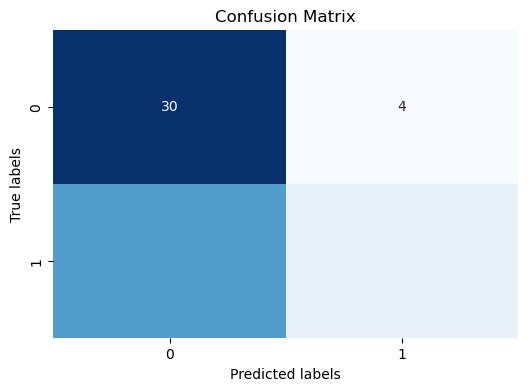

In [810]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

model = SVC(kernel='linear')

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(y_test, y_pred)

print("Matrice di confusione:")
print(conf_matrix)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


Accuracy: 0.6271186440677966
[[29  5]
 [17  8]]


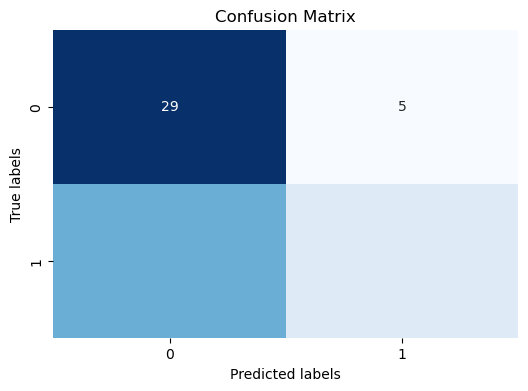

In [811]:
model = LogisticRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(conf_matrix)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Accuracy: 0.6440677966101694


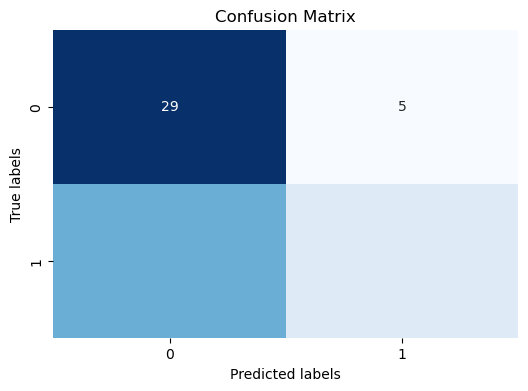

In [812]:
from sklearn.ensemble import RandomForestClassifier


rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

predictions = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()




In [813]:
# Creare un DataFrame delle feature importances
print(len(rf_model.feature_importances_))
feature_importances = pd.DataFrame(rf_model.feature_importances_, index=range(len(df_features.columns)), columns=['Importance'])

# Ordinare le feature importances in ordine decrescente
feature_importances_sorted = feature_importances.sort_values(by='Importance', ascending=False)

# Ottenere l'elenco delle colonne delle feature
cols = df_features.columns
print(len(cols))

# Stampare le feature importances
print("Feature Importances:")
for idx in feature_importances_sorted.index:
    print(cols[idx])


30
30
Feature Importances:
P6_PeakValue
P1_BandPower
P1_median
P6_min
P5_BandPower
P7_crest_factor
P5_fft_min
P6_crest_factor
P6_impulse_factor
P7_fft_min
P7_BandPower
P4_HarmonicAmplitudeRatio
P7_impulse_factor
P2_crest_factor
P6_fft_min
P7_PeakValue
P3_HarmonicAmplitudeRatio
P4_min
P3_PeakValue
P5_impulse_factor
P6_HarmonicAmplitudeRatio
P5_HarmonicAmplitudeRatio
P2_PeakValue
P1_impulse_factor
P2_impulse_factor
P1_PeakValue
P5_crest_factor
P1_crest_factor
P5_PeakValue
P7_SINAD


In [814]:
n_top_features = 80  

top_feature_importances = feature_importances_sorted.head(n_top_features)

top_feature_columns = cols[top_feature_importances.index]

print("Top Feature Columns:")
print(top_feature_columns.tolist())

Top Feature Columns:
['P6_PeakValue', 'P1_BandPower', 'P1_median', 'P6_min', 'P5_BandPower', 'P7_crest_factor', 'P5_fft_min', 'P6_crest_factor', 'P6_impulse_factor', 'P7_fft_min', 'P7_BandPower', 'P4_HarmonicAmplitudeRatio', 'P7_impulse_factor', 'P2_crest_factor', 'P6_fft_min', 'P7_PeakValue', 'P3_HarmonicAmplitudeRatio', 'P4_min', 'P3_PeakValue', 'P5_impulse_factor', 'P6_HarmonicAmplitudeRatio', 'P5_HarmonicAmplitudeRatio', 'P2_PeakValue', 'P1_impulse_factor', 'P2_impulse_factor', 'P1_PeakValue', 'P5_crest_factor', 'P1_crest_factor', 'P5_PeakValue', 'P7_SINAD']
